# Simple synthetic example

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import swspy
import numpy as np
import os, sys
import matplotlib 
import matplotlib.pyplot as plt
from scipy import signal
import obspy
%matplotlib notebook
import time


### 0. Specify whether want to recreate synthetics, or use existing ones:

(Use existing ones for exact reproducability due to randomness of noise)

In [3]:
create_synthetics = False

### 1. Create source-time function:

<IPython.core.display.Javascript object>


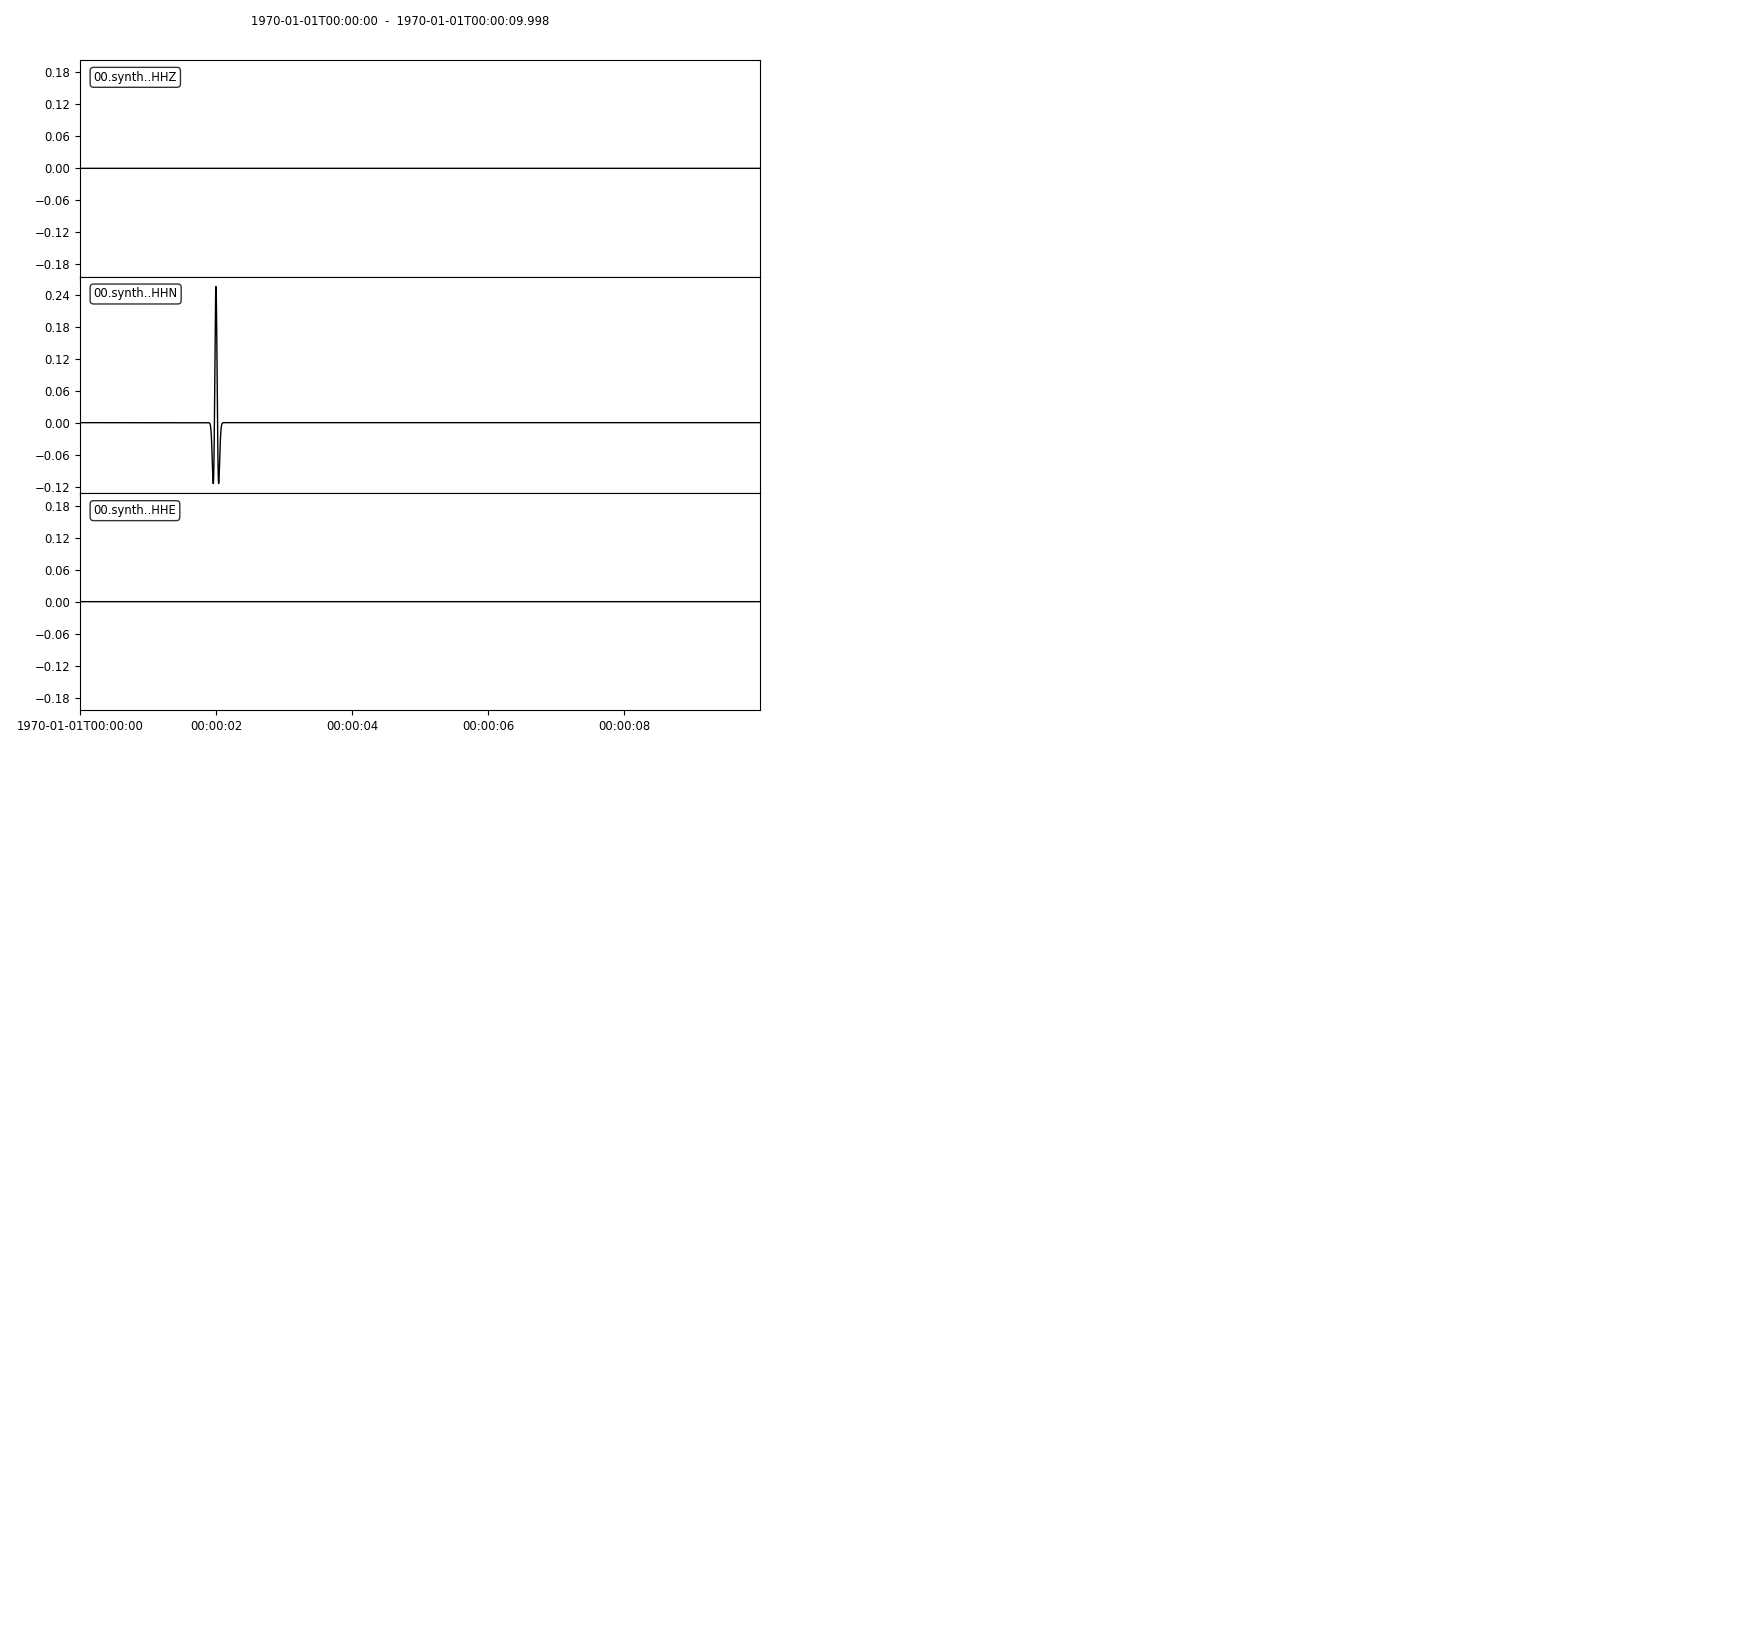

<IPython.core.display.Javascript object>


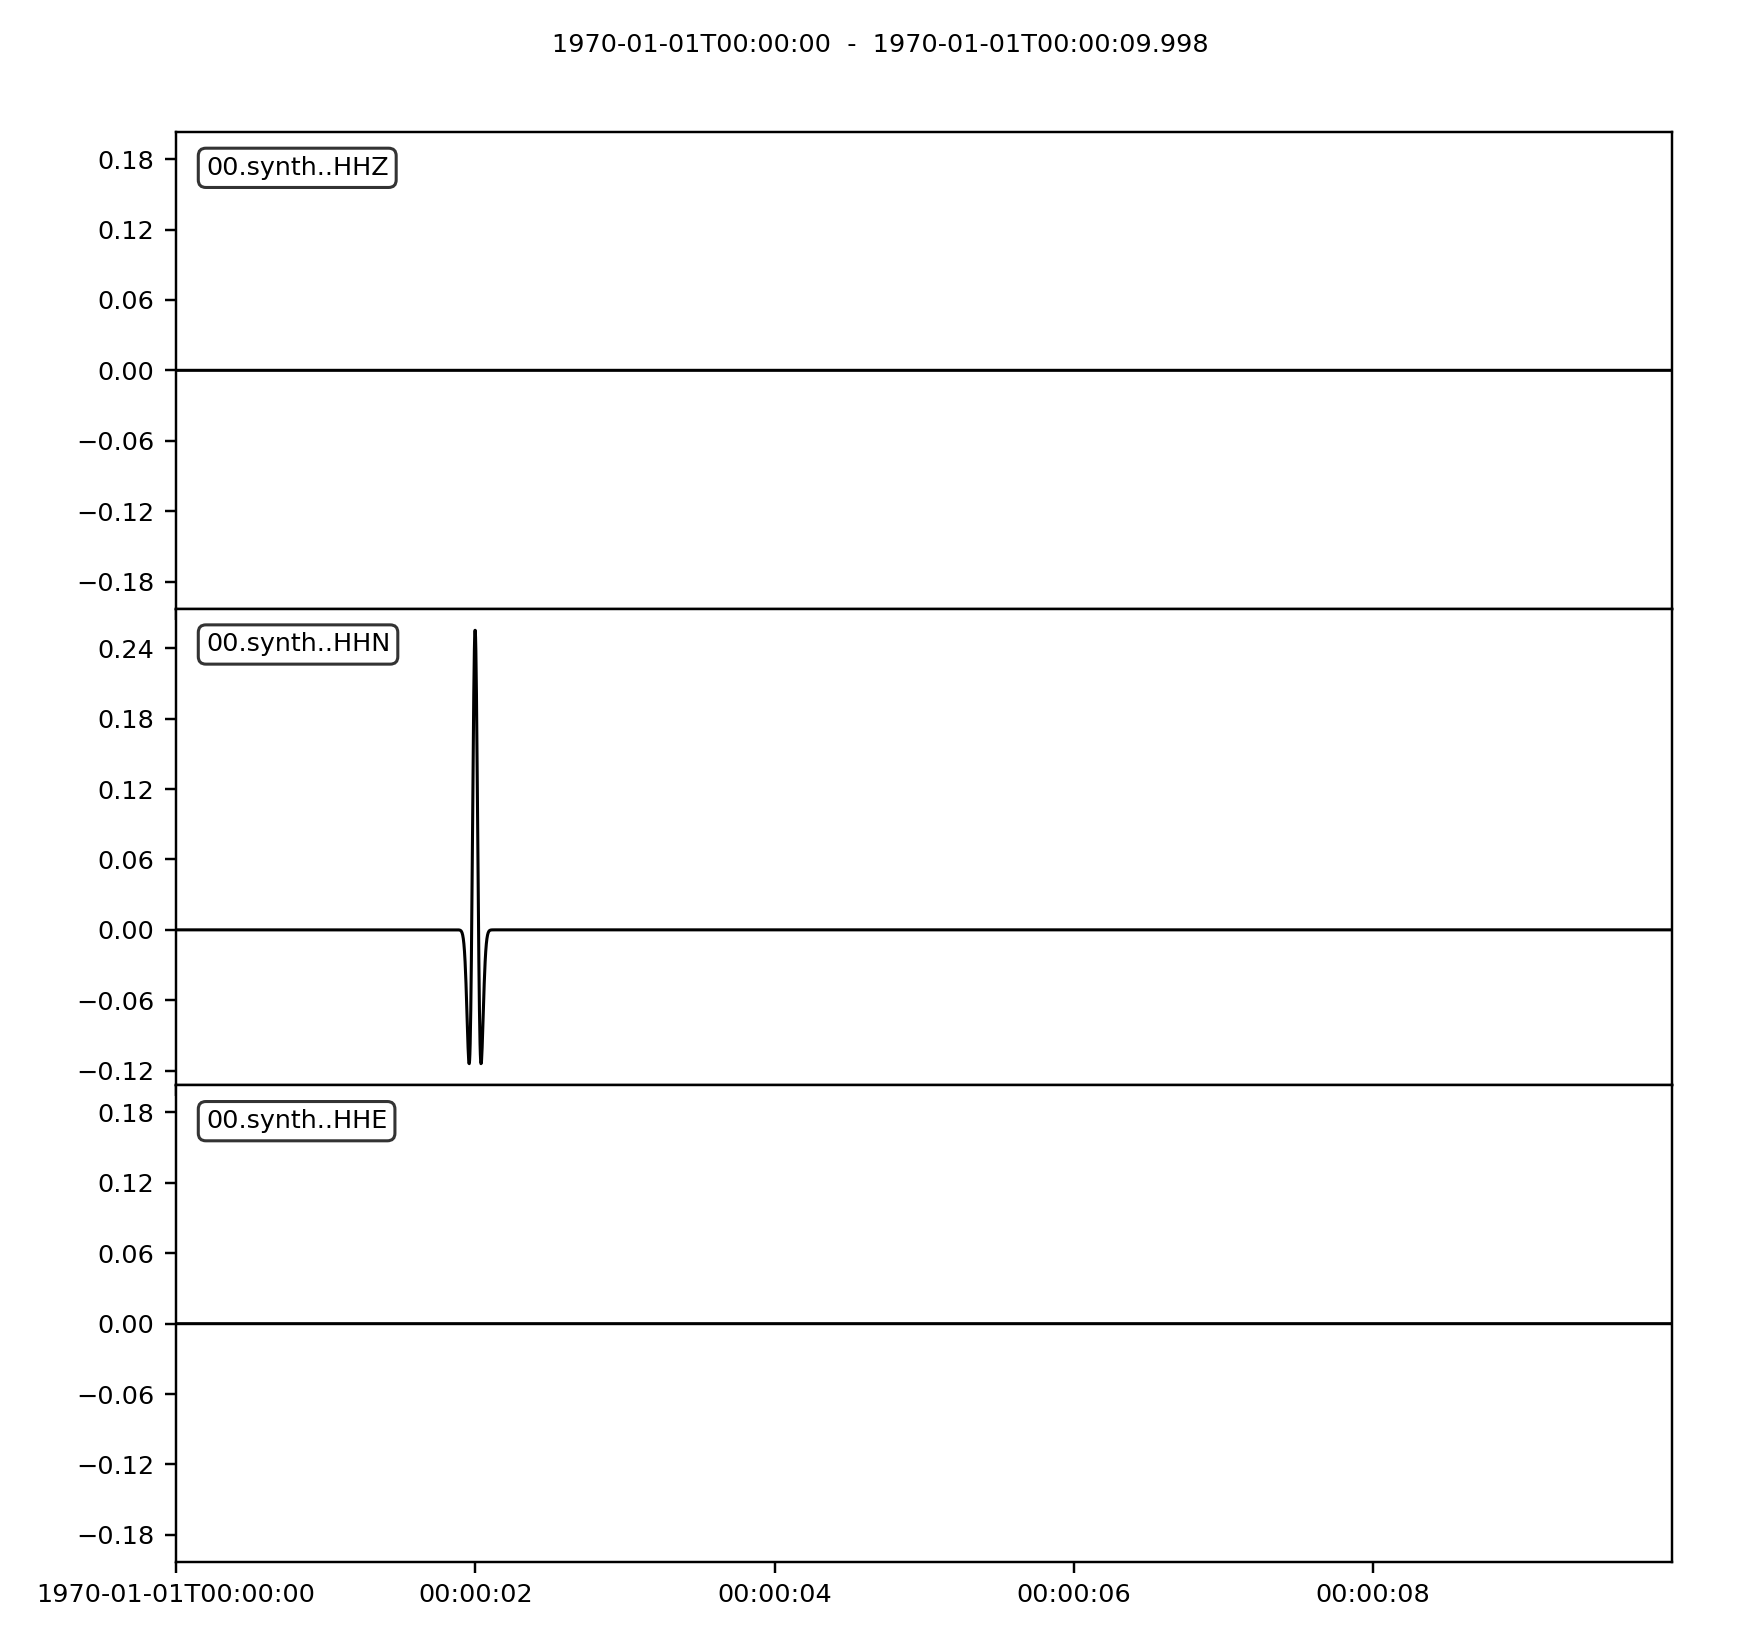

In [4]:
# Create source-time function:
t_src = 2.0
src_pol_from_N = 0.0
src_dur = 10.
fs = 500 #1000.
if create_synthetics:
    ZNE_st = swspy.splitting.forward_model.create_src_time_func(src_dur, fs, src_pol_from_N=src_pol_from_N, src_pol_from_up=0, t_src=t_src)
else:
    ZNE_st = obspy.read(os.path.join("data", "ZNE_st.mseed"))
ZNE_st.plot()


### 2. Apply a layer of splitting:

In [5]:
# Define SNR:
snr = 1000 #100 #1000 #100 # SNR of the src time func (applied so that get non-zero eigenvalue ratio for multi-layer splitting)


<IPython.core.display.Javascript object>


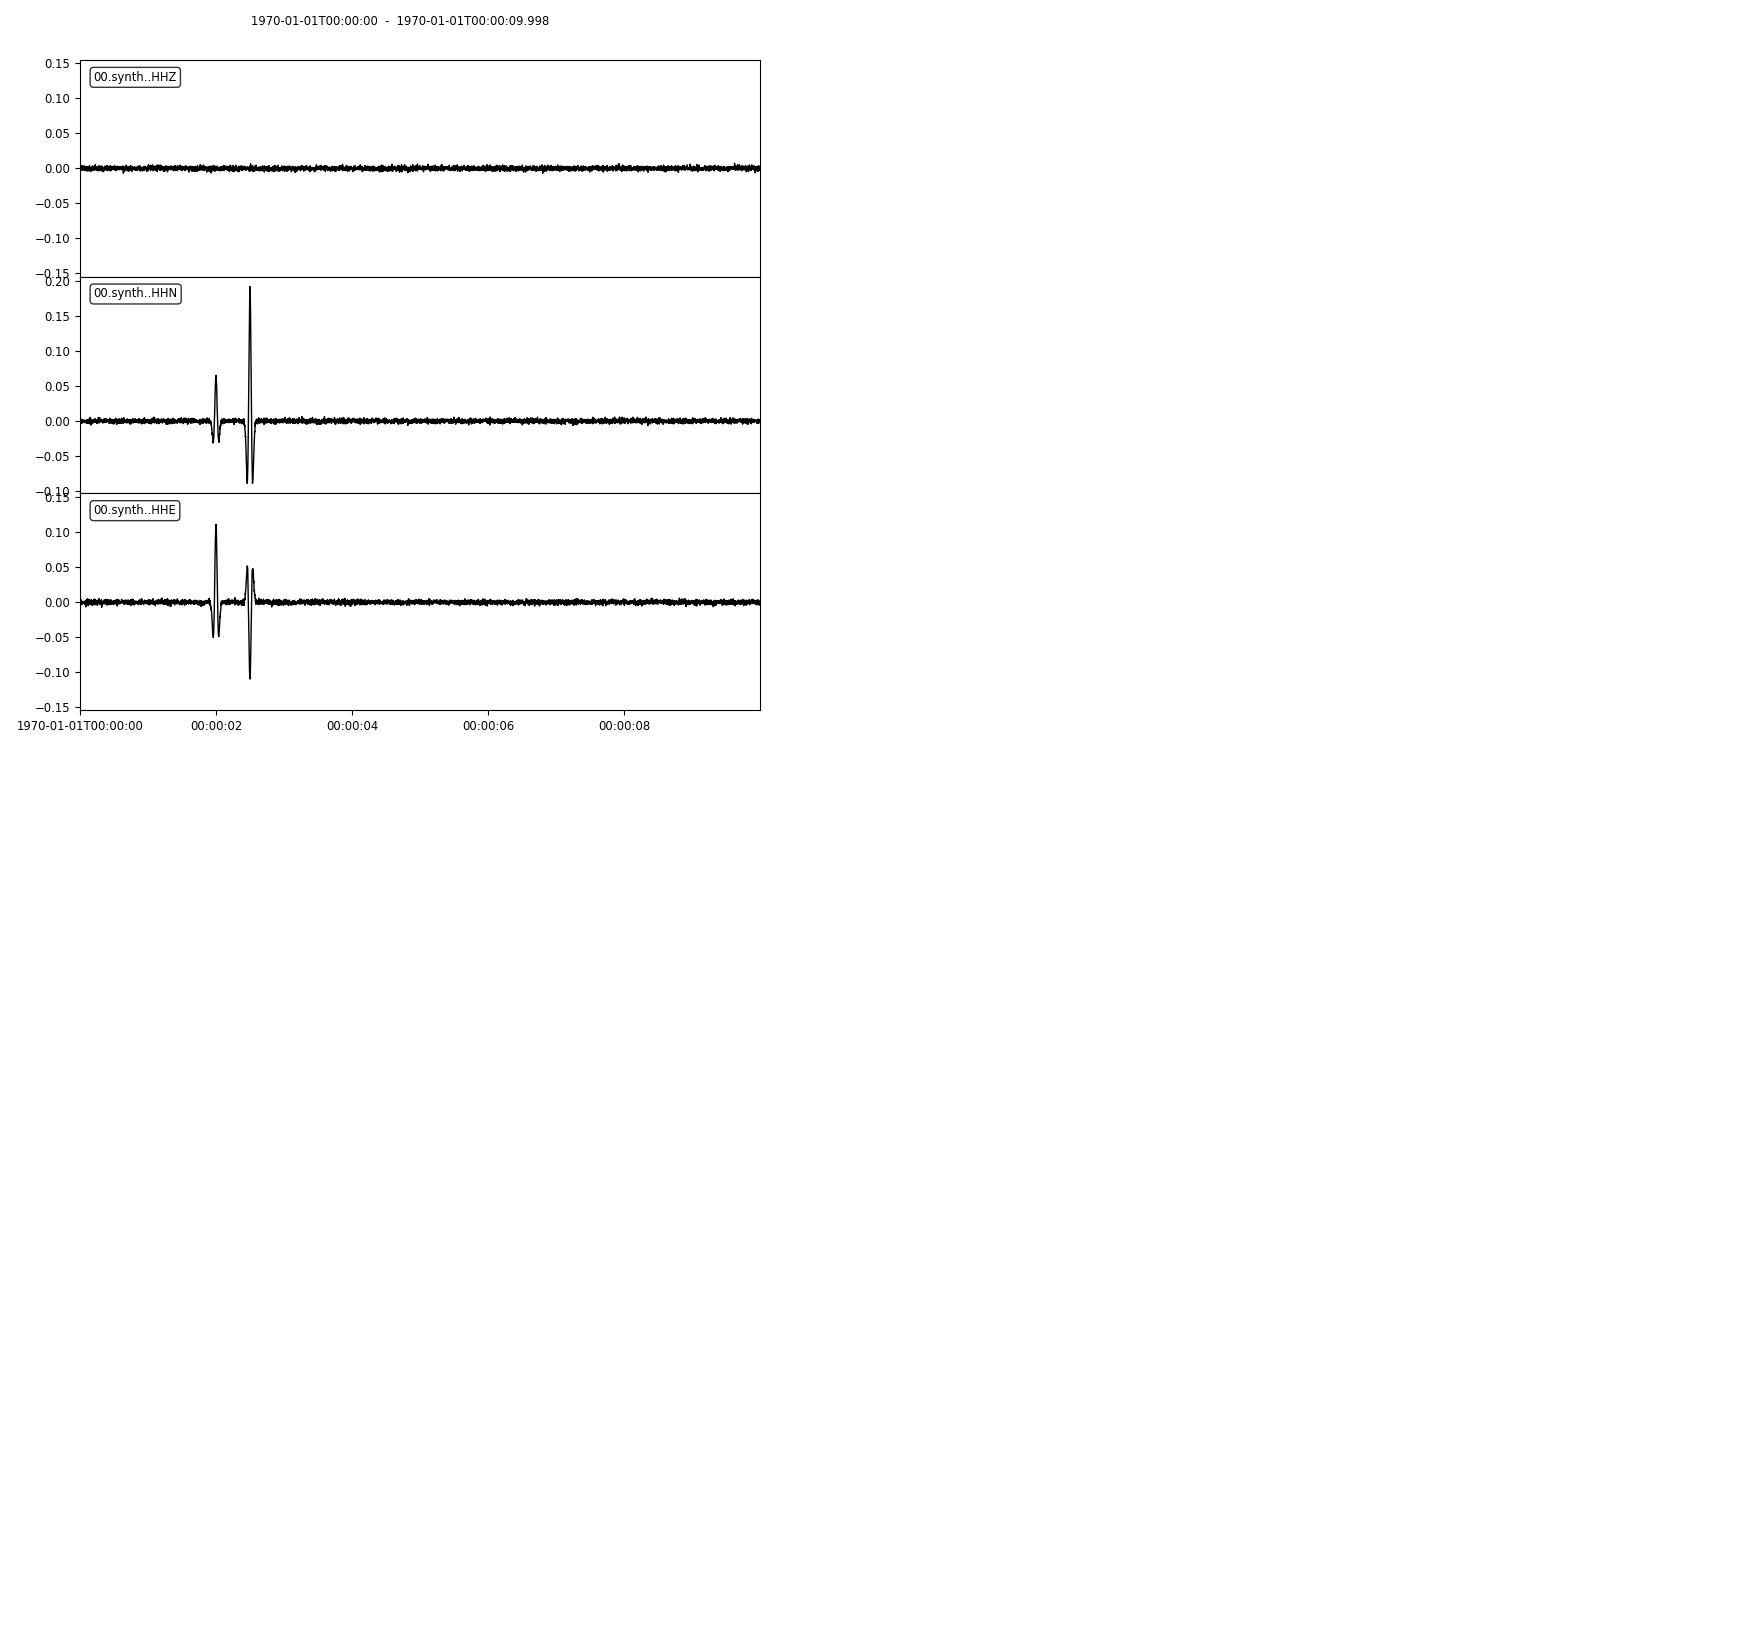

<IPython.core.display.Javascript object>


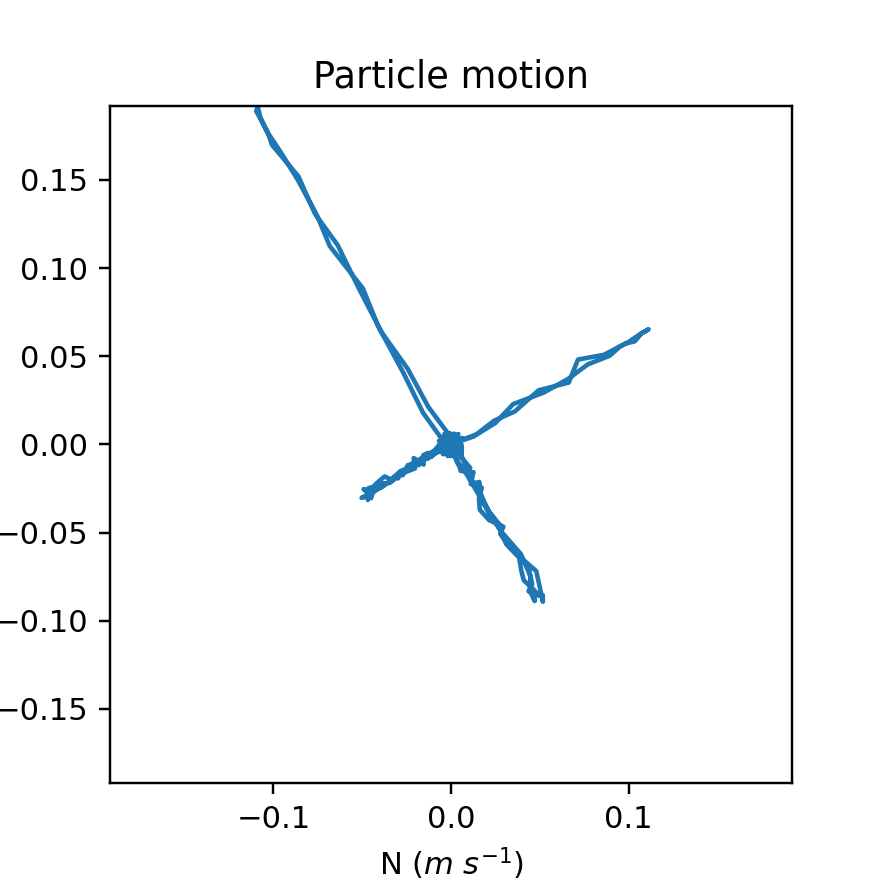

In [6]:
# Specify layer anisotropy parameters:
phi_from_N = 60.
dt = 0.5 #0.05
back_azi = 0
event_inclin_angle_at_station = 0

# Apply splitting:
if create_synthetics:
    ZNE_st_layer1 = swspy.splitting.forward_model.add_splitting(ZNE_st, phi_from_N, dt, back_azi, event_inclin_angle_at_station, snr=snr)
else:
    ZNE_st_layer1 = obspy.read(os.path.join("data", "ZNE_st_layer1.mseed"))
ZNE_st_layer1.plot()

plt.figure(figsize=(4,4))
plt.plot(ZNE_st_layer1.select(channel="??E")[0].data, ZNE_st_layer1.select(channel="??N")[0].data)
abs_max_tmp = np.max(np.array([np.max(np.abs(ZNE_st_layer1.select(channel="??N")[0].data)), np.max(np.abs(ZNE_st_layer1.select(channel="??E")[0].data))]))
plt.xlim([-abs_max_tmp, abs_max_tmp])
plt.ylim([-abs_max_tmp, abs_max_tmp])
plt.title("Particle motion")
plt.xlabel("E ($m$ $s^{-1}$)")
plt.xlabel("N ($m$ $s^{-1}$)")
plt.show()


### 3. Measure splitting on single layer:

In [7]:
# Measure splitting:
measure_single_splitting = False
if measure_single_splitting:
    event_uid = "single-layer"
    S_phase_arrival_times = [ZNE_st_layer1[0].stats.starttime+t_src]
    back_azis_all_stations = [back_azi]
    receiver_inc_angles_all_stations = [event_inclin_angle_at_station]
    splitting_event = swspy.splitting.create_splitting_object(ZNE_st_layer1, event_uid=event_uid, stations_in=["synth"], S_phase_arrival_times=S_phase_arrival_times, back_azis_all_stations=back_azis_all_stations, receiver_inc_angles_all_stations=receiver_inc_angles_all_stations) 
    splitting_event.overall_win_start_pre_fast_S_pick = 0.5
    splitting_event.win_S_pick_tolerance = 0.2
    splitting_event.overall_win_start_post_fast_S_pick = 1.0
    splitting_event.rotate_step_deg = 2 #1.0 
    splitting_event.max_t_shift_s = 0.75 #1.0
    splitting_event.n_win = 10
    start_time = time.time()
    splitting_event.perform_sws_analysis(coord_system="ZNE", sws_method="EV")
    end_time = time.time()
    print("Time taken (s):", end_time-start_time)

    # And plot splitting result:
    splitting_event.plot(outdir=os.path.join("outputs", "plots"))

    # And save result to file:
    splitting_event.save_result(outdir=os.path.join("outputs", "data"))

## Multi-layer splitting

### 4. Apply a second layer of splitting:

<IPython.core.display.Javascript object>


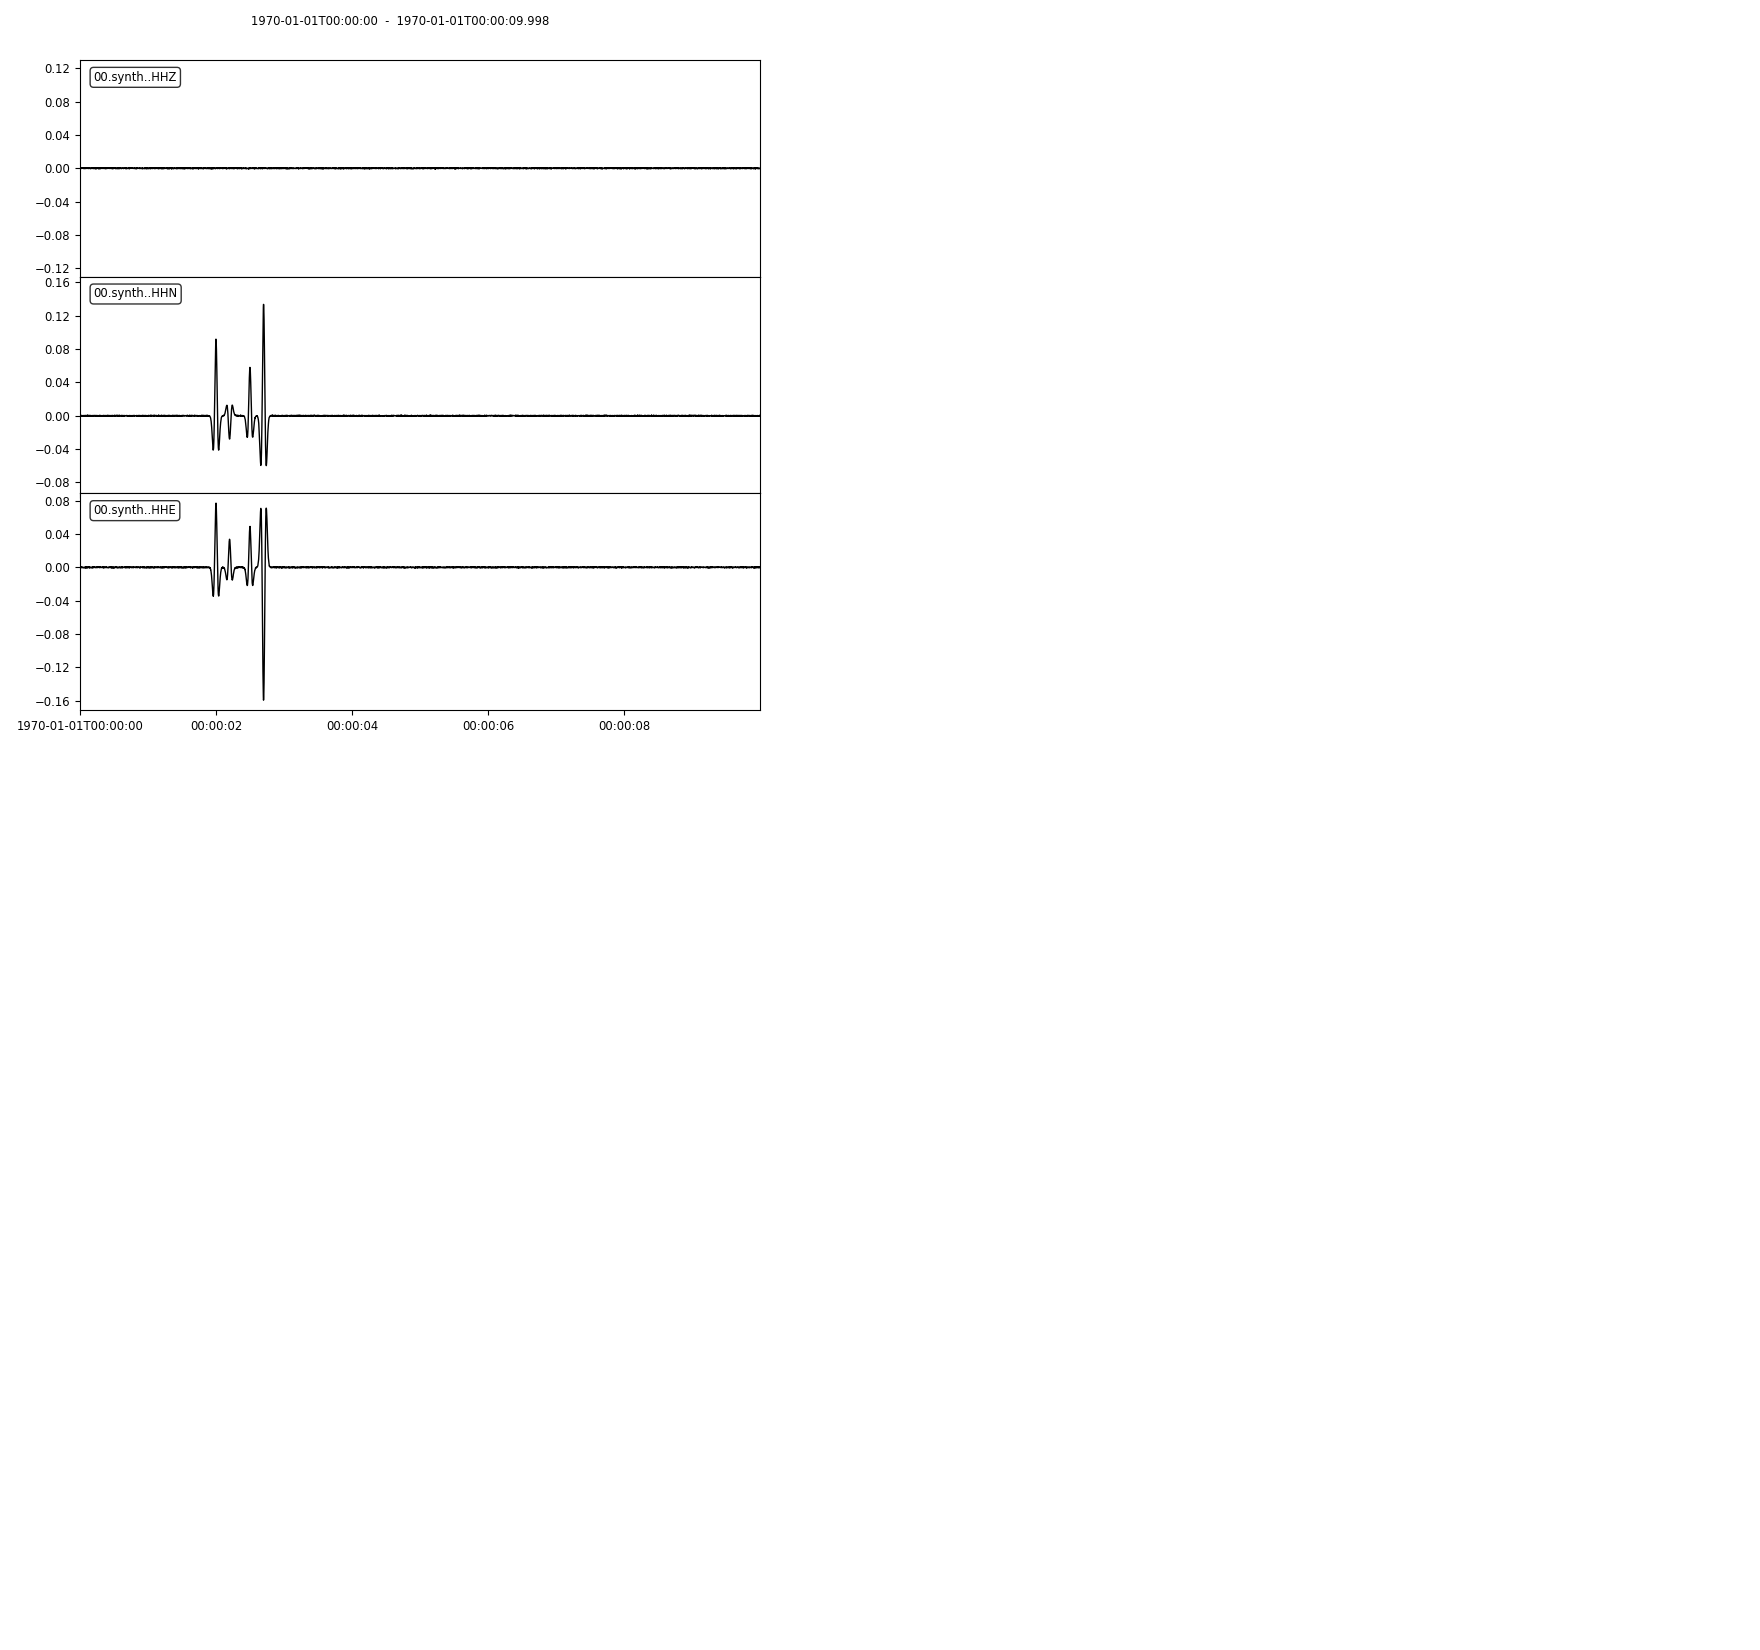

<IPython.core.display.Javascript object>


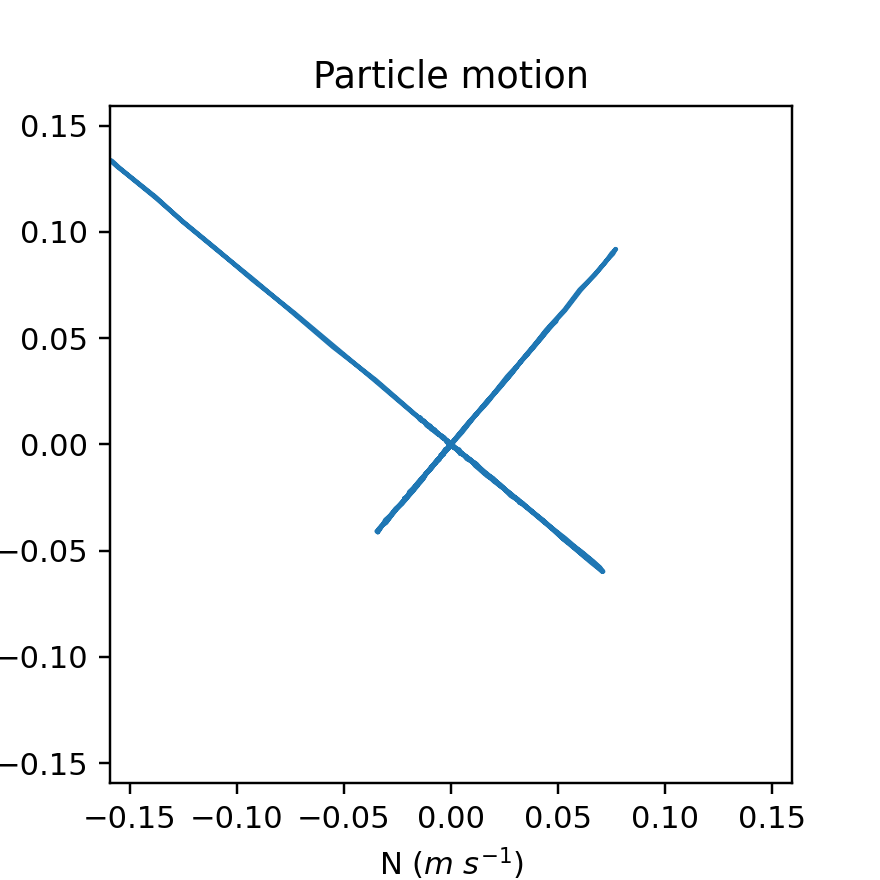

In [8]:
# Specify second layer parameters:
phi_from_N_layer2 = 40. #20.
dt_layer2 = 0.2 #0.05
# back_azi = 0
# event_inclin_angle_at_station = 0

# Apply splitting:
if create_synthetics:
    ZNE_st_layer1_no_noise = swspy.splitting.forward_model.add_splitting(ZNE_st, phi_from_N, dt, back_azi, event_inclin_angle_at_station, snr=snr) #, snr=snr*2)
    ZNE_st_layer1and2 = swspy.splitting.forward_model.add_splitting(ZNE_st_layer1_no_noise, phi_from_N_layer2, dt_layer2, back_azi, event_inclin_angle_at_station, snr=snr)
else:
    ZNE_st_layer1and2 = obspy.read(os.path.join("data", "ZNE_st_layer1and2.mseed"))
ZNE_st_layer1and2.plot()

plt.figure(figsize=(4,4))
plt.plot(ZNE_st_layer1and2.select(channel="??E")[0].data, ZNE_st_layer1and2.select(channel="??N")[0].data)
abs_max_tmp = np.max(np.array([np.max(np.abs(ZNE_st_layer1and2.select(channel="??N")[0].data)), np.max(np.abs(ZNE_st_layer1and2.select(channel="??E")[0].data))]))
plt.xlim([-abs_max_tmp, abs_max_tmp])
plt.ylim([-abs_max_tmp, abs_max_tmp])
plt.title("Particle motion")
plt.xlabel("E ($m$ $s^{-1}$)")
plt.xlabel("N ($m$ $s^{-1}$)")
plt.show()


### 5. And measure multi-layer splitting (using explicit method):

(Note: Important to start S-wave window as close to/before S-wave pick for this example)

Passed multi-layer result, therefore plotting this result.


<IPython.core.display.Javascript object>


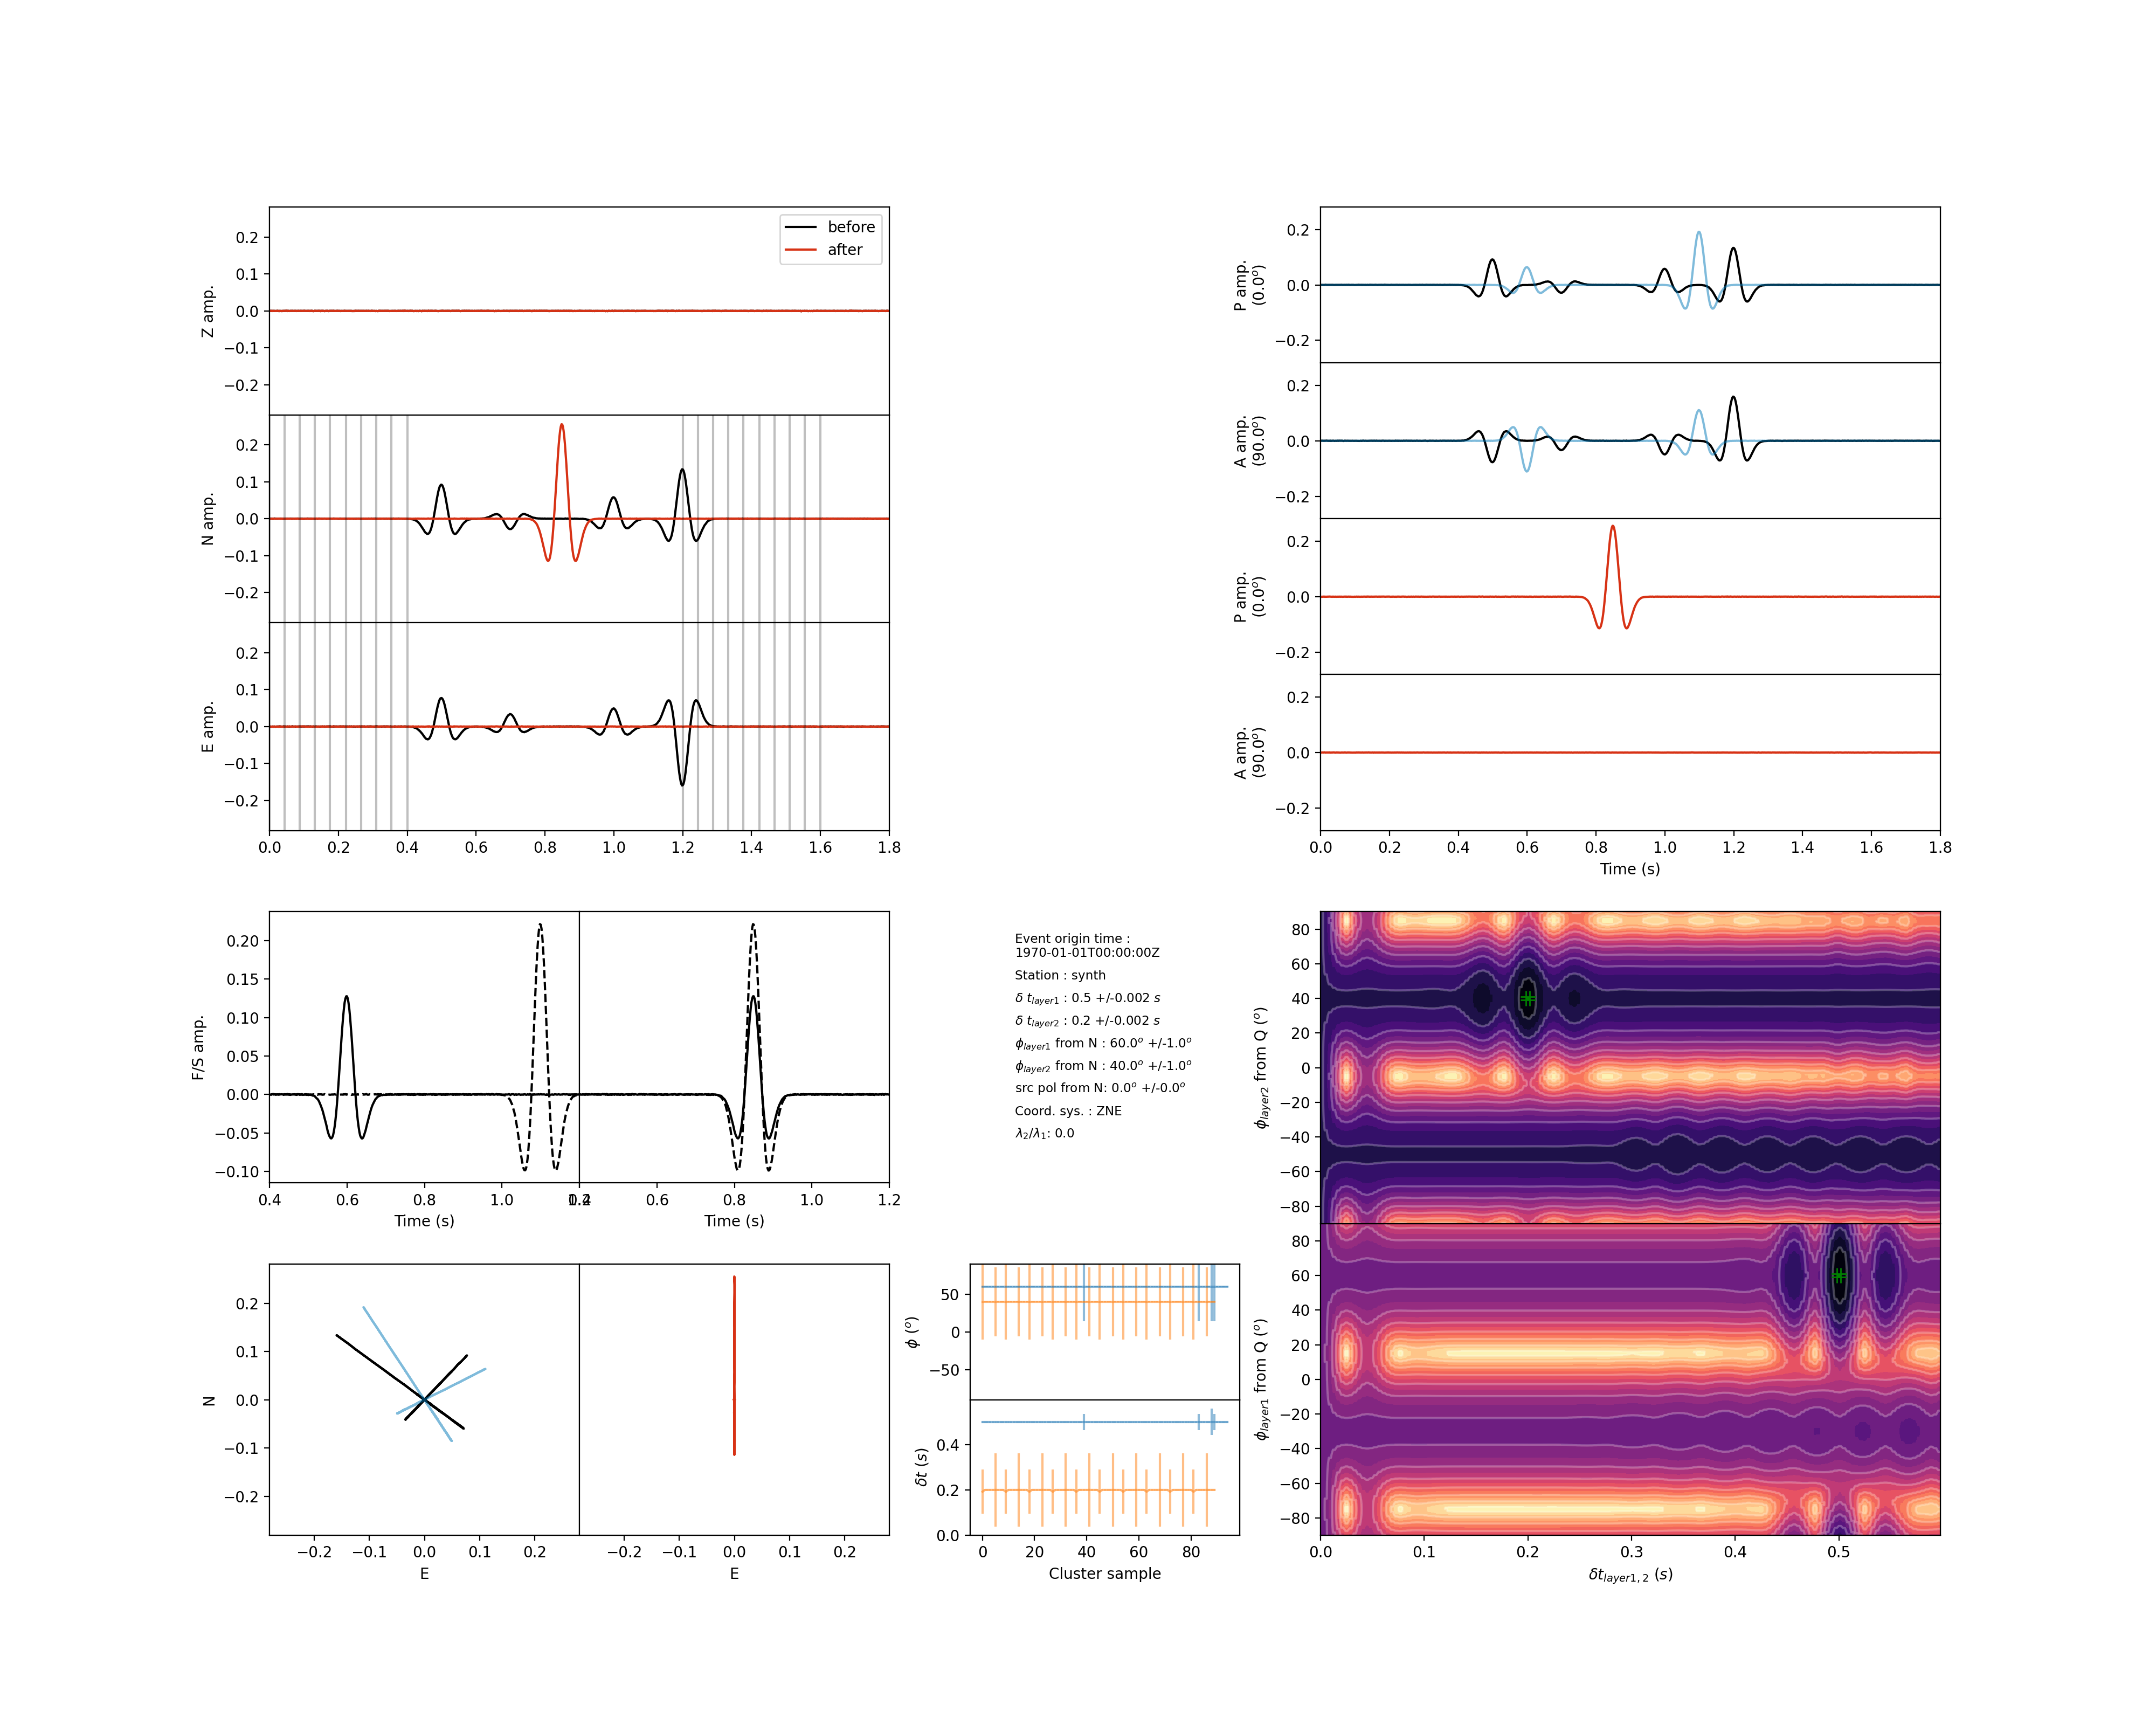

/Users/eart0504/Documents/python/github_repositories/swspy/swspy/splitting/split.py:1898: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  plt.savefig(os.path.join(outdir, ''.join((self.event_uid, "_", station, ".png"))), dpi=300)


Saved sws result to: outputs/data/multi-layer_sws_result.csv


In [10]:
# Measure splitting for multi-layer:
measure_multi_layer_explicit_splitting = False
if measure_multi_layer_explicit_splitting:
    event_uid = "multi-layer"
    S_phase_arrival_times = [ZNE_st_layer1and2[0].stats.starttime+t_src]
    back_azis_all_stations = [back_azi]
    receiver_inc_angles_all_stations = [event_inclin_angle_at_station]
    splitting_event_multi_layer = swspy.splitting.create_splitting_object(ZNE_st_layer1and2, event_uid=event_uid, stations_in=["synth"], S_phase_arrival_times=S_phase_arrival_times, back_azis_all_stations=back_azis_all_stations, receiver_inc_angles_all_stations=receiver_inc_angles_all_stations) 
    splitting_event_multi_layer.overall_win_start_pre_fast_S_pick = 0.5 #0.4 #0.3 #0.5
    splitting_event_multi_layer.win_S_pick_tolerance = 0.1 ##0.1 #0.2 #0.15 #0.1
    splitting_event_multi_layer.overall_win_start_post_fast_S_pick = 0.7 #0.7 #0.7 #0.8 #1.0
    splitting_event_multi_layer.rotate_step_deg = 2. #1. #2.5 #2. #1. #5 #2.0 
    splitting_event_multi_layer.max_t_shift_s = 0.6 #0.8 ##0.7 #0.75 #0.7 #1.0 
    splitting_event_multi_layer.n_win = 10 #4 #10 
    splitting_event_multi_layer.perform_sws_analysis_multi_layer(coord_system="ZNE")

    # Plot and save result:
    splitting_event_multi_layer.plot(outdir=os.path.join("outputs", "plots"))
    splitting_event_multi_layer.save_result(outdir=os.path.join("outputs", "data"))

### 6. And measure multi-layer splitting (using direct method, for comparison):

In [9]:
# ZNE_st_layer1and2_downsamp = ZNE_st_layer1and2.copy()
# ZNE_st_layer1and2_downsamp.decimate(2, no_filter=True)

--- Calculating multi-layer splitting pairs from apparent splitting parameters ---
-36.0 0.5 9.98890122087


<IPython.core.display.Javascript object>


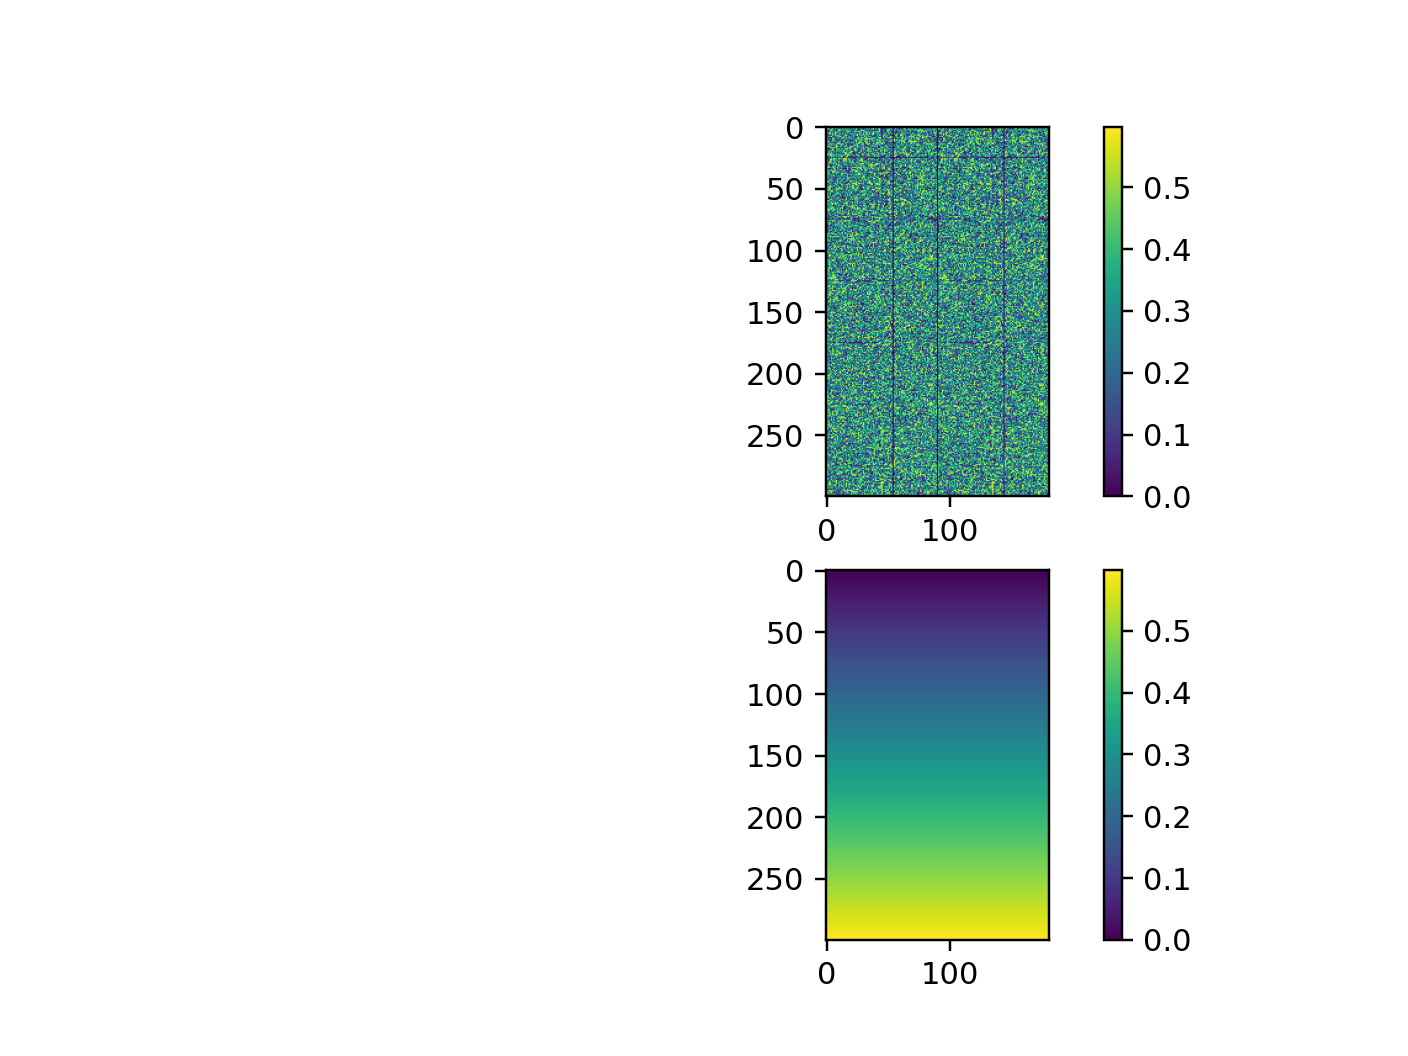

<IPython.core.display.Javascript object>


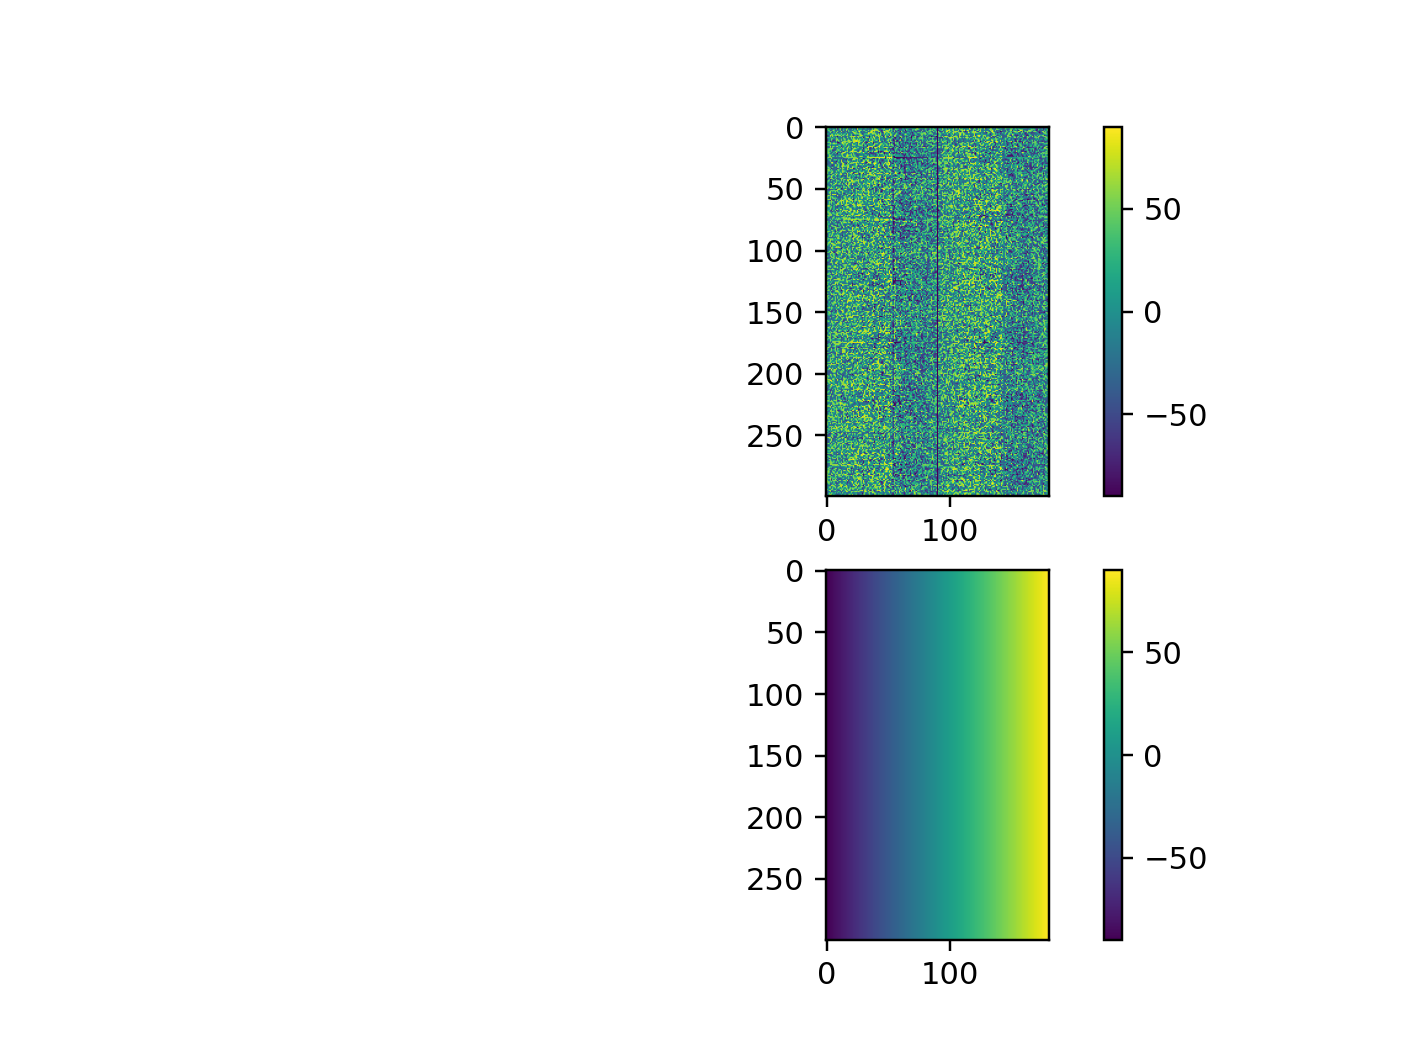

<IPython.core.display.Javascript object>


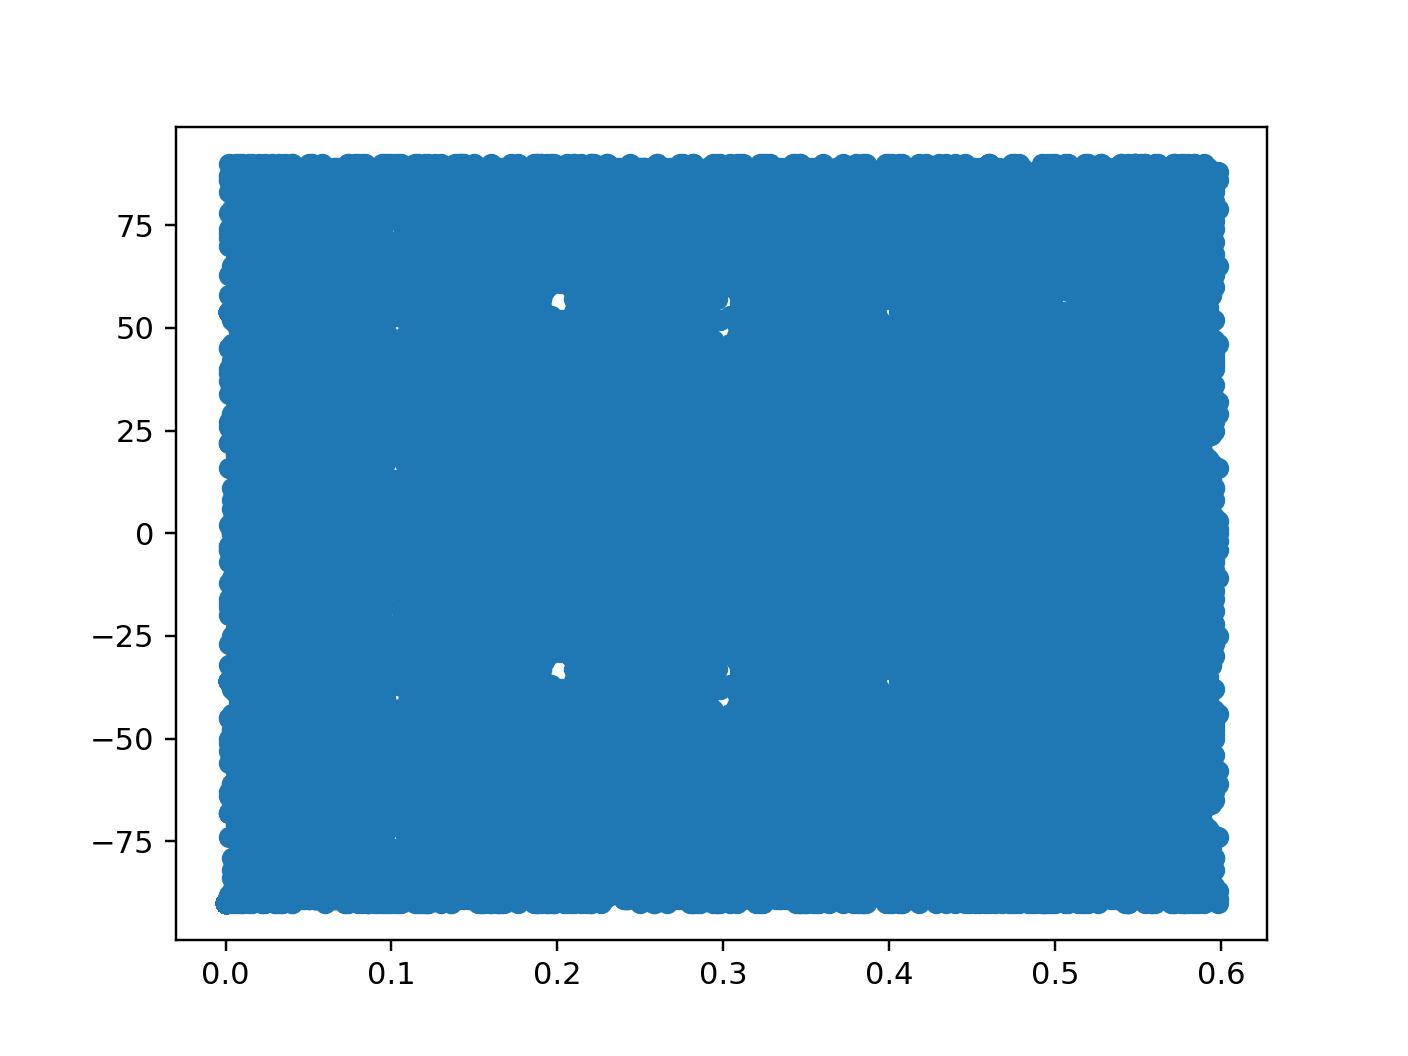

--- Finished calculating multi-layer splitting pairs from apparent splitting parameters ---
Time taken (s): 99.18380212783813
Passed multi-layer result, therefore plotting this result.


<IPython.core.display.Javascript object>


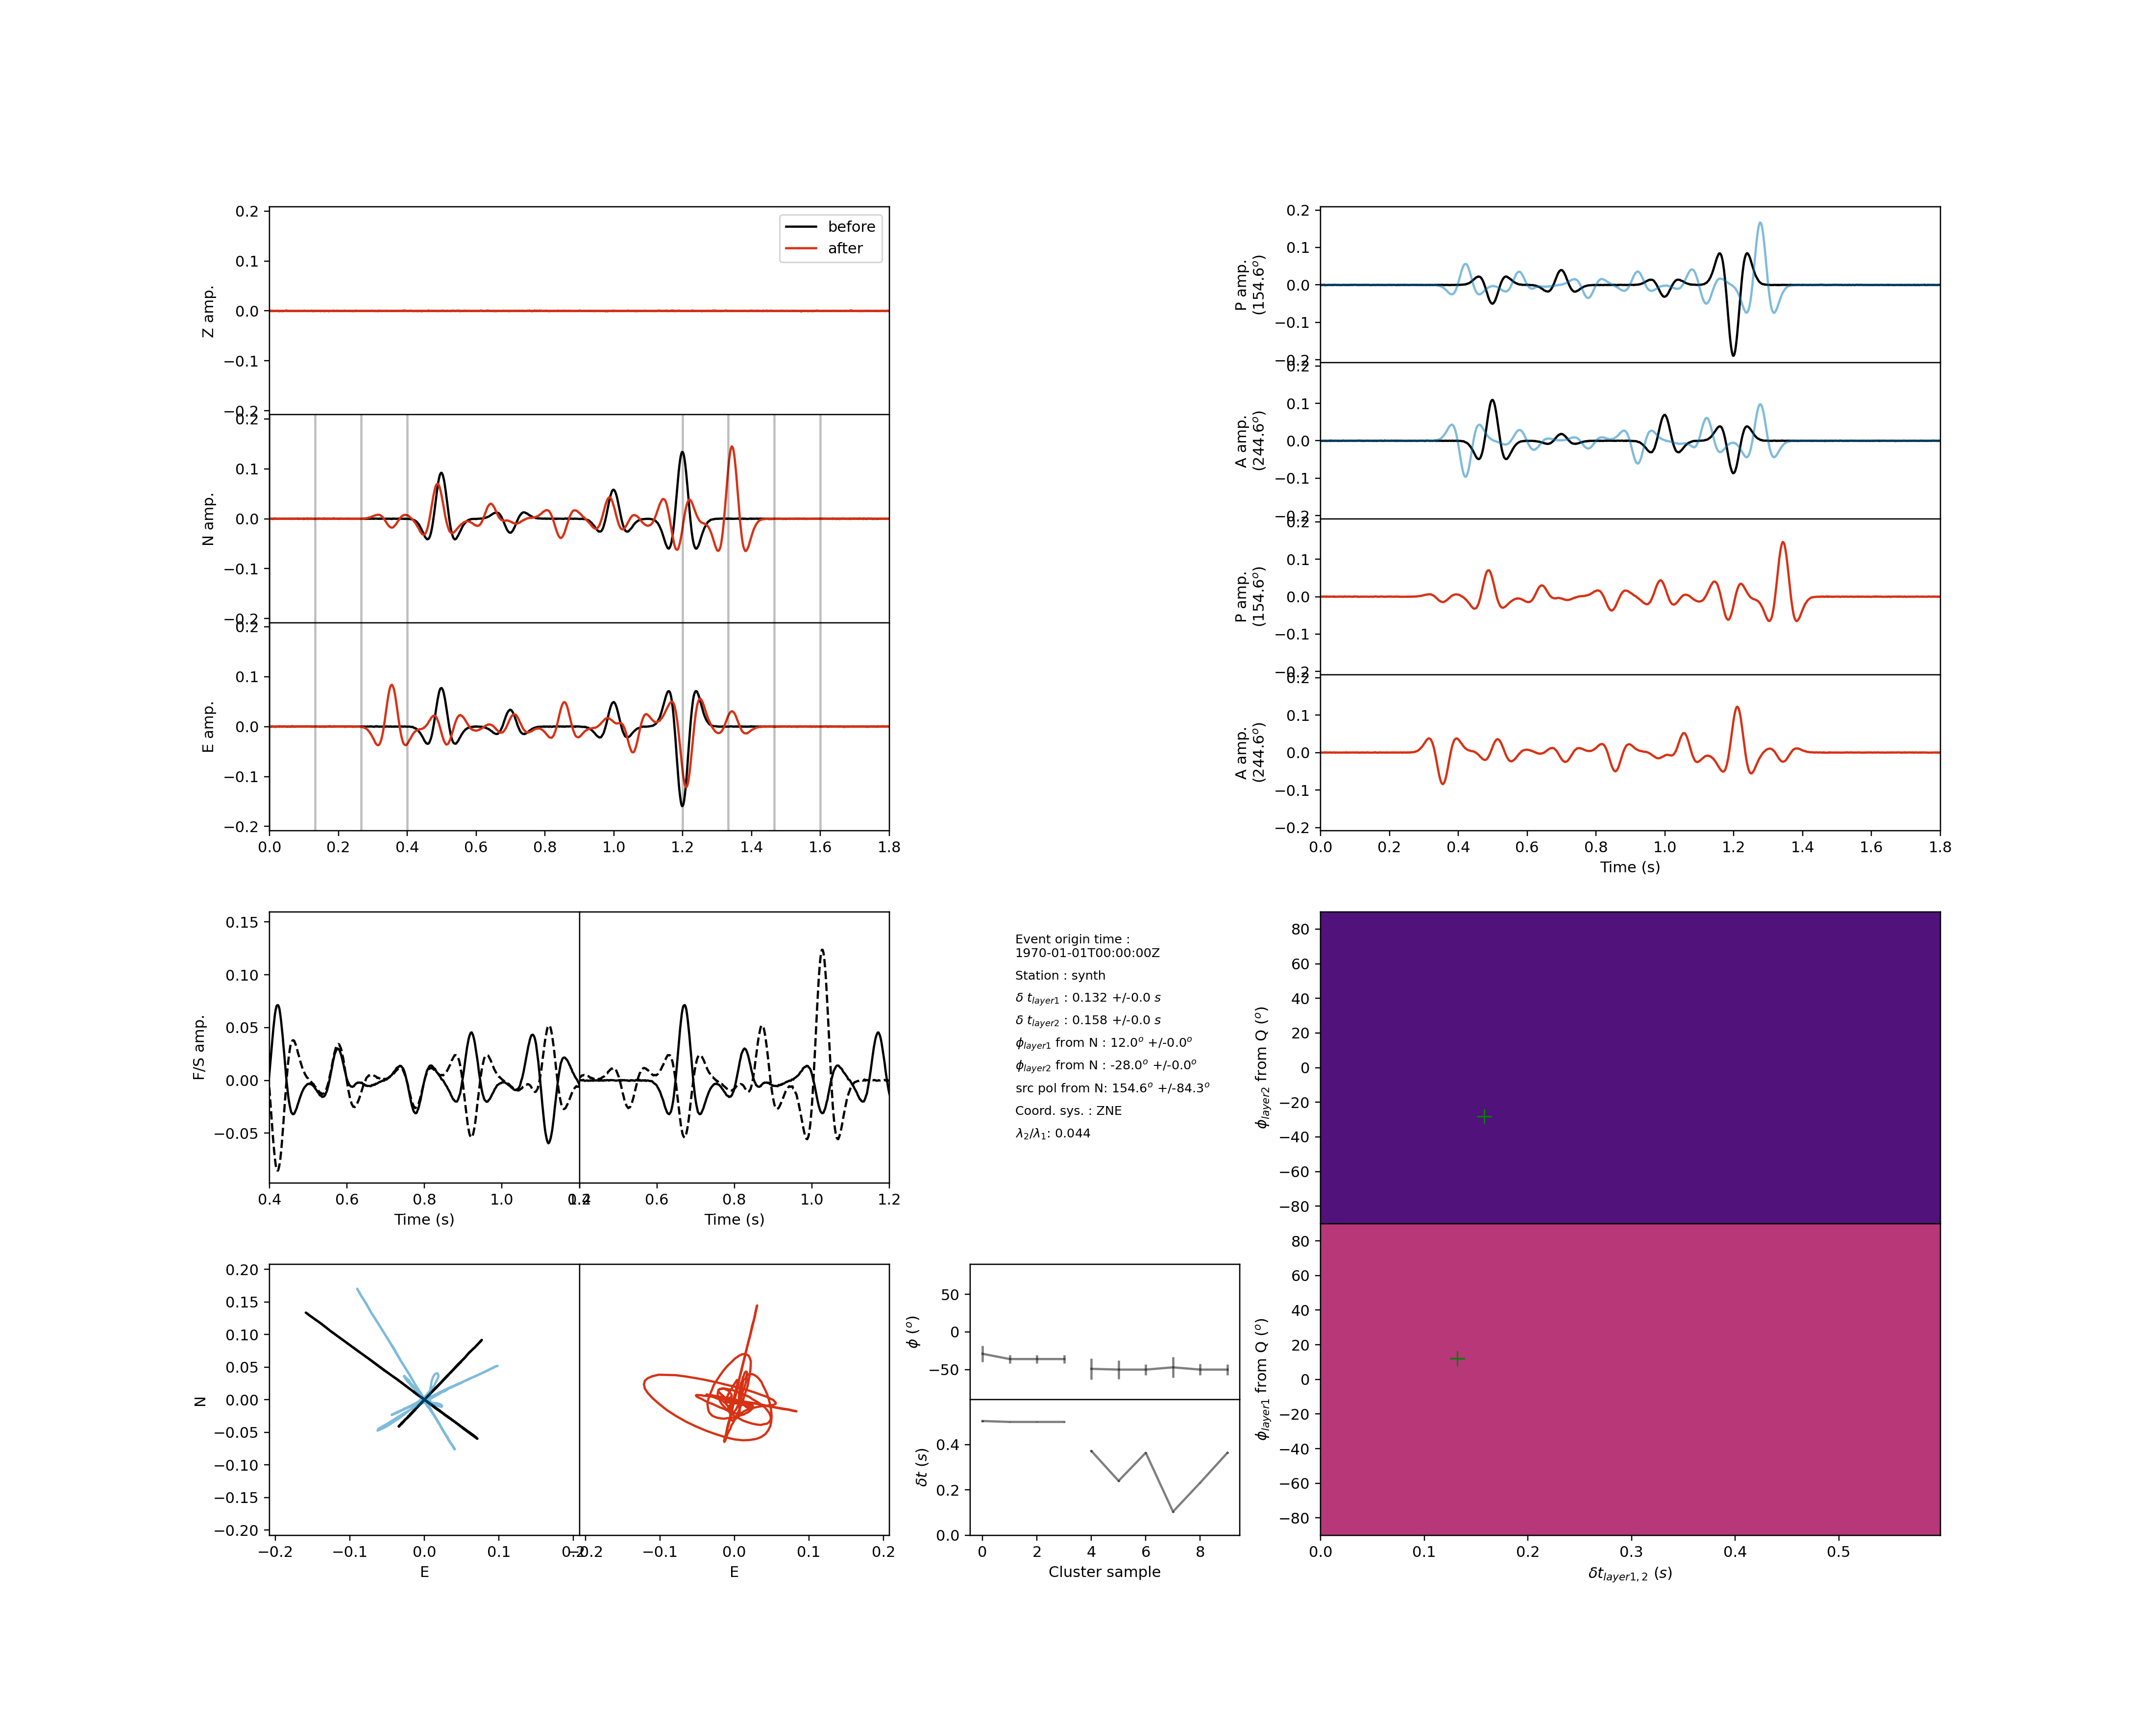

/Users/eart0504/Documents/python/github_repositories/swspy/swspy/splitting/split.py:2042: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  plt.savefig(os.path.join(outdir, ''.join((self.event_uid, "_", station, ".png"))), dpi=300)


Saved sws result to: outputs/data/multi-layer_direct_method_sws_result.csv


In [10]:
# Measure splitting for multi-layer:
measure_multi_layer_direct_splitting = True
if measure_multi_layer_direct_splitting:
    event_uid = "multi-layer_direct_method"
    S_phase_arrival_times = [ZNE_st_layer1and2[0].stats.starttime+t_src]
    back_azis_all_stations = [back_azi]
    receiver_inc_angles_all_stations = [event_inclin_angle_at_station]
    splitting_event_multi_layer_direct_inv = swspy.splitting.create_splitting_object(ZNE_st_layer1and2, event_uid=event_uid, stations_in=["synth"], S_phase_arrival_times=S_phase_arrival_times, back_azis_all_stations=back_azis_all_stations, receiver_inc_angles_all_stations=receiver_inc_angles_all_stations) 
    splitting_event_multi_layer_direct_inv.overall_win_start_pre_fast_S_pick = 0.5 
    splitting_event_multi_layer_direct_inv.win_S_pick_tolerance = 0.1
    splitting_event_multi_layer_direct_inv.overall_win_start_post_fast_S_pick = 0.7 
    splitting_event_multi_layer_direct_inv.rotate_step_deg = 1. #2. #5
    splitting_event_multi_layer_direct_inv.max_t_shift_s = 0.6 #0.75 #0.7 #1.0 
    splitting_event_multi_layer_direct_inv.n_win = 4 #5 #10 #10 #2 
    start_time = time.time()
    splitting_event_multi_layer_direct_inv.perform_sws_analysis_multi_layer(coord_system="ZNE", multi_layer_method="direct")
    end_time = time.time()
    print("Time taken (s):", end_time-start_time)

    # Plot and save result:
    splitting_event_multi_layer_direct_inv.plot(outdir=os.path.join("outputs", "plots"))
    splitting_event_multi_layer_direct_inv.save_result(outdir=os.path.join("outputs", "data"))


## And measure effective splitting, assuming single layer, for comparison:

In [32]:
# Measure splitting:
measure_multi_layer_effective_splitting = False
if measure_multi_layer_effective_splitting:
    event_uid = "multi-layer-effective"
    S_phase_arrival_times = [ZNE_st_layer1and2[0].stats.starttime+t_src]
    back_azis_all_stations = [back_azi]
    receiver_inc_angles_all_stations = [event_inclin_angle_at_station]
    splitting_event = swspy.splitting.create_splitting_object(ZNE_st_layer1and2, event_uid=event_uid, stations_in=["synth"], S_phase_arrival_times=S_phase_arrival_times, back_azis_all_stations=back_azis_all_stations, receiver_inc_angles_all_stations=receiver_inc_angles_all_stations) 
    splitting_event.overall_win_start_pre_fast_S_pick = 0.5
    splitting_event.win_S_pick_tolerance = 0.1 #0.2
    splitting_event.overall_win_start_post_fast_S_pick = 0.7 #1.0
    splitting_event.rotate_step_deg = 2 #1.0 
    splitting_event.max_t_shift_s = 0.6 #0.75 #1.0
    splitting_event.n_win = 10
    splitting_event.perform_sws_analysis(coord_system="ZNE", sws_method="EV")

    # And plot splitting result:
    splitting_event.plot(outdir=os.path.join("outputs", "plots"))

    # And save result to file:
    splitting_event.save_result(outdir=os.path.join("outputs", "data"))

In [47]:
# Testing of new direct method:
phi_app = 40
dt_app = 0.2
rotate_step_deg = 5 #2
n_t_steps = 20 #100
fs = 50
dom_freq_Hz = 60
dt_app, rotate_step_deg, n_t_steps, fs, dom_freq_Hz
layer_1_dts_phis, layer_2_dts_phis = swspy.splitting.split._find_multi_layer_splitting_pairs_for_direct_method(phi_app, dt_app, rotate_step_deg, n_t_steps, fs, dom_freq_Hz)


<IPython.core.display.Javascript object>


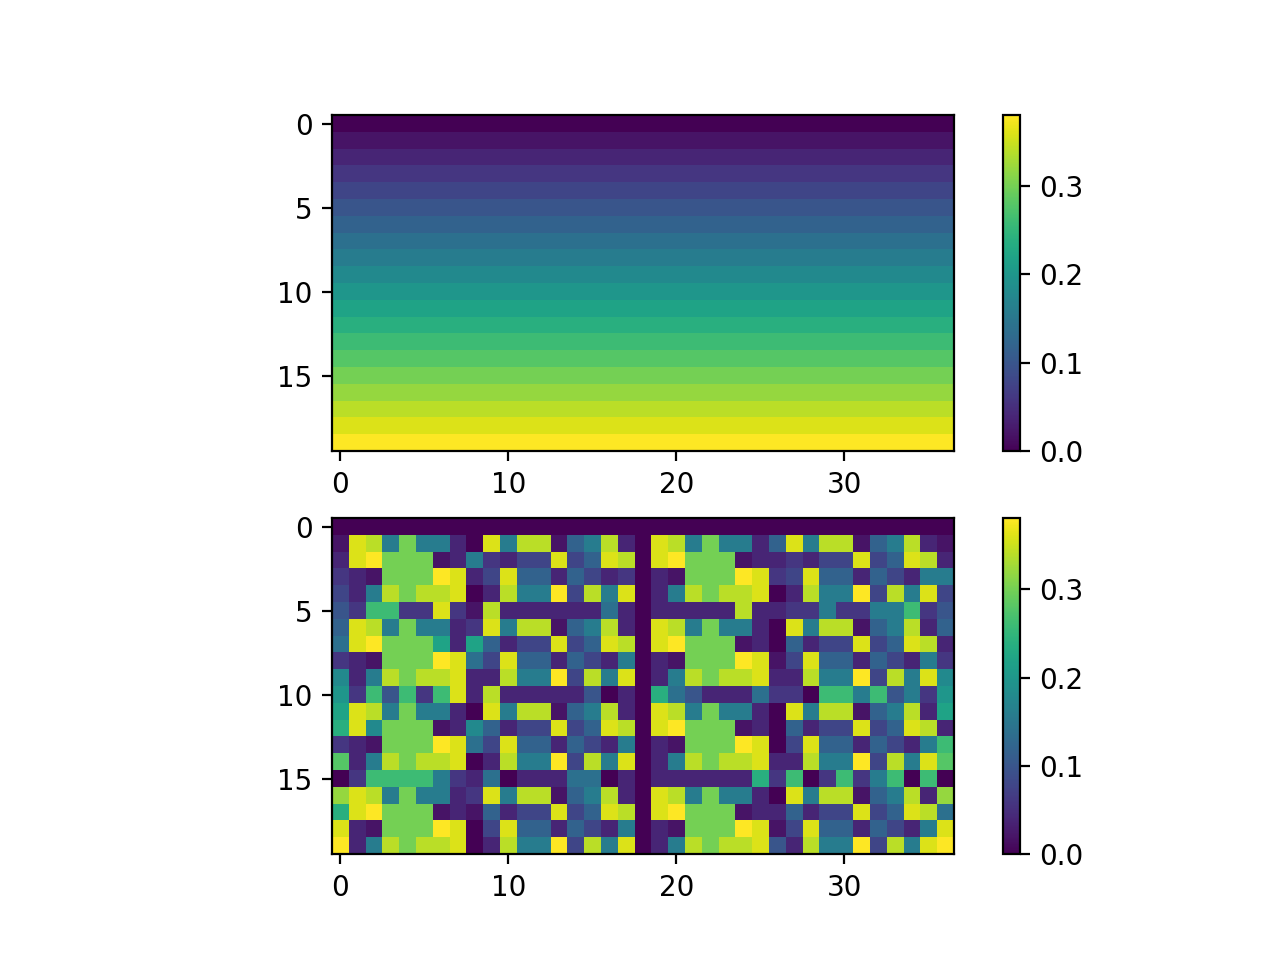

<IPython.core.display.Javascript object>


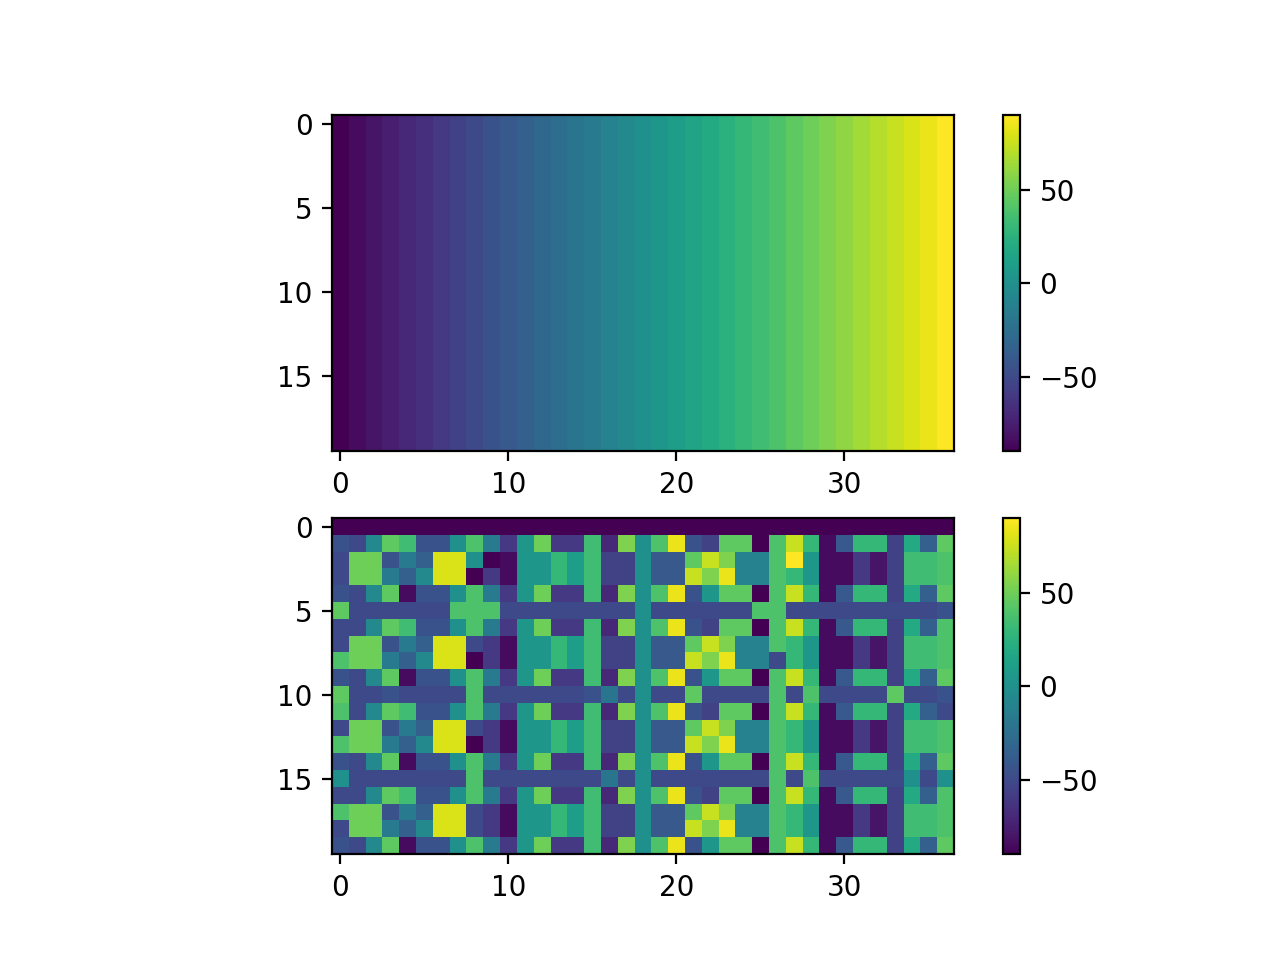

In [49]:
fig, ax = plt.subplots(nrows=2)
s1 = ax[0].imshow(layer_1_dts_phis[:,:,0])
s2 = ax[1].imshow(layer_2_dts_phis[:,:,0])
fig.colorbar(s1, ax=ax[0])
fig.colorbar(s2, ax=ax[1])
plt.show()

fig, ax = plt.subplots(nrows=2)
s1 = ax[0].imshow(layer_1_dts_phis[:,:,1])
s2 = ax[1].imshow(layer_2_dts_phis[:,:,1])
fig.colorbar(s1, ax=ax[0])
fig.colorbar(s2, ax=ax[1])
plt.show()


In [44]:
print(layer_1_dts_phis[6,6,1], layer_2_dts_phis[6,6,1])
print(layer_1_dts_phis[6,6,1], layer_2_dts_phis2[6,6,1])

-60.0 -45.0
-60.0 30.0


To do next:

1. Run _phi_dt_grid_search_direct_multi_layer() for new search
2. Try to speed up _find_multi_layer_splitting_pairs_for_direct_method()

<IPython.core.display.Javascript object>


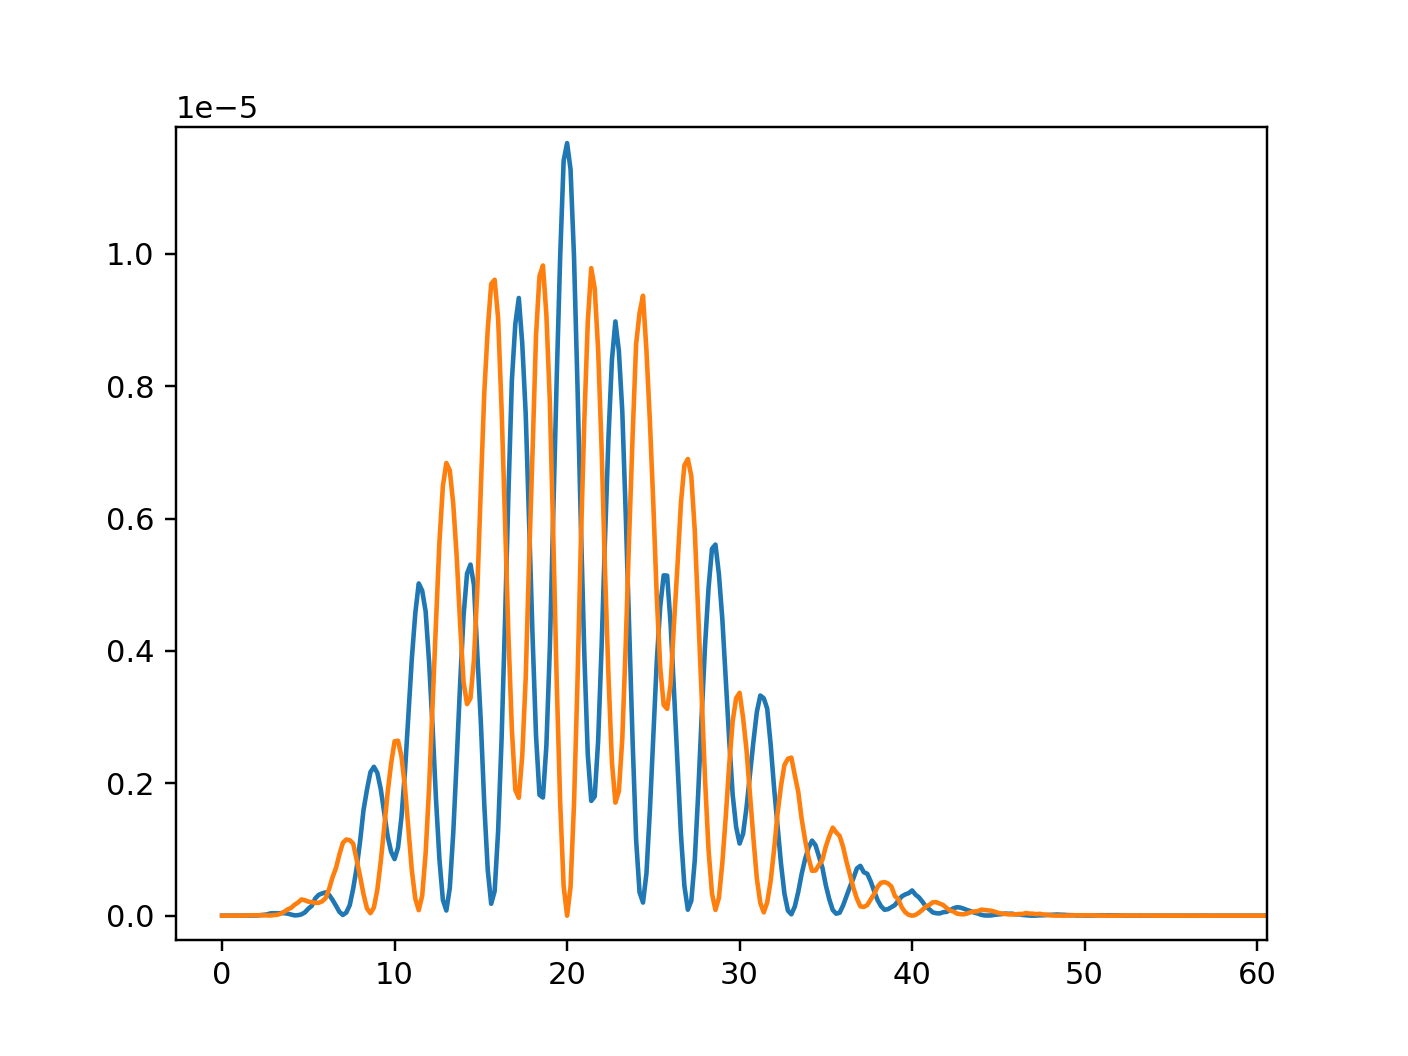

20.0

In [16]:
swspy.splitting.split._find_dom_freq(ZNE_st_layer1and2_downsamp.select(channel="??N")[0].data, ZNE_st_layer1and2_downsamp.select(channel="??E")[0].data, fs)
